# Start Here

In [1]:
import os

from pydantic import BaseModel
from tqdm import tqdm

from dreidel.apps.extractors import functional as F
from dreidel.apps.extractors.feature_extractor import FeatureExtractor
from dreidel.apps.extractors.schema import Feature, Values
from dreidel.schemas.ped import PEDSchema
from dreidel.utils.loaders.local_loader import LocalFileLoader

## Configure Hyperparameters

## Download The Data

In [1]:
from dataclasses import dataclass
from pathlib import Path


@dataclass
class Config:
    root:Path = Path.cwd().parent
    data_root:Path = Path("/home/thinkpad/projects/dreidel/data/")
    extractors:tuple = ('ext_min','ext_max','ext_avg')

cfg = Config()

In [4]:
from dreidel.utils.downloaders import GDownDownloader

downloader = GDownDownloader(root = cfg.data_root / "raw")
downloader.download(url='https://drive.google.com/u/0/uc?id=1l_hRL08BmSCLLdapLBdZRTt2QlsYpQFo', output='ped')
downloader.download(url='https://drive.google.com/u/0/uc?id=1vevHJHc4CMu_vP79IurflFjXeGfhfUwP', output='eels') 

KeyboardInterrupt: 

In [2]:
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import scipy.special as sp
from PIL import Image



In [47]:
def quantile(sourcepath:Path, savepath:Path):
    lst = []
    filenames = glob(str(sourcepath))
    for filename in filenames:
        print(filename)
        img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        lst.append(img/255.0)
    img = np.quantile(np.array(lst), q=0.2, axis=0)
    savepath.mkdir(parents=True, exist_ok=True)
    plt.imshow(img)
    plt.imsave(str(savepath/"cleaned.png"), img)

/home/thinkpad/projects/dreidel/data/processed/ped/images/ext_avg.png
/home/thinkpad/projects/dreidel/data/processed/ped/images/ext_min.png
/home/thinkpad/projects/dreidel/data/processed/ped/images/ext_max.png


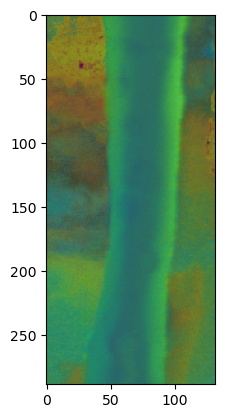

In [48]:
filepath = cfg.data_root /"processed"/"ped"/"images"/"*.png"
img_path = Path(cfg.data_root /"processed"/"ped")
quantile(filepath, img_path)

In [4]:
filepath = cfg.data_root / "raw"/ "eels" / "*.tif"
img_path = Path(cfg.data_root /"processed"/"eels")
quantile(filepath, img_path)

/home/thinkpad/projects/dreidel/data/raw/eels/Zr L Percent Composition (EELS).tif
/home/thinkpad/projects/dreidel/data/raw/eels/Cu L Percent Composition (EELS).tif
/home/thinkpad/projects/dreidel/data/raw/eels/Ni L Percent Composition (EELS).tif
/home/thinkpad/projects/dreidel/data/raw/eels/Al K Percent Composition (EELS).tif


## Parse Data

In [5]:
loader = LocalFileLoader(root=cfg.data_root/"raw"/"ped", schema=PEDSchema)
ped_data = [loader.parse_item(loader.root/item) for item in loader.items]
extractor = FeatureExtractor(cfg.data_root/"processed"/"ped")

for extractor_name in cfg.extractors:
    extractor.build_extractor(extractor_name)
    extractor.run(ped_data)

100%|██████████| 38148/38148 [00:00<00:00, 56613.54it/s]


In [14]:
loader = LocalFileLoader(root=cfg.data_root/"processed/ped", schema=Feature)
data = [loader.parse_item(loader.root/item) for item in loader.items]

In [21]:
import os
import abc

import matplotlib.pyplot as plt
import numpy as np

class Visualiser:
    def __init__(self, root: Path, save: bool = True) -> None:
        self.root = root
        self.save = save
      
    def run(self, feature):
        grid = np.zeros(shape=(289, 132))
        
        for value in tqdm(feature.value):
            grid[value.x][value.y] = value.value
        path = self.root / "ped" / "images"
        path.mkdir(parents=True, exist_ok=True)
        
        if self.save:
            plt.imsave(str(path/ f"{feature.extractor}.png"), grid)
        
        plt.show()

In [22]:
vis = Visualiser(root=Path(cfg.data_root/"processed"))
for item in data:
    vis.run(item)

100%|██████████| 38148/38148 [00:00<00:00, 3234370.51it/s]


In [10]:
from dreidel.apps.aligner import StepAligner
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import cv2

align_cfg = OmegaConf.load("/home/thinkpad/projects/dreidel/conf/base.yml")

aligner = StepAligner(align_cfg.aligner)
img_path = cv2.imread(str(cfg.data_root/"processed"/"images"/"ext_max.png"))
tgt_path = cv2.imread(str(cfg.data_root/"processed"/"eels"/"cleaned.png"))
matched = aligner.run(str(img_path), str(tgt_path))

plt.imshow(matched)

[ WARN:0@568.608] global /home/conda/feedstock_root/build_artifacts/libopencv_1671461518131/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/thinkpad/projects/dreidel/data/processed/images/ext_max.png'): can't open/read file: check file path/integrity


AttributeError: 'function' object has no attribute 'copy'

[ WARN:0@569.425] global /home/conda/feedstock_root/build_artifacts/libopencv_1671461518131/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/thinkpad/projects/dreidel/data/processed/aligned.png'): can't open/read file: check file path/integrity


TypeError: Image data of dtype object cannot be converted to float

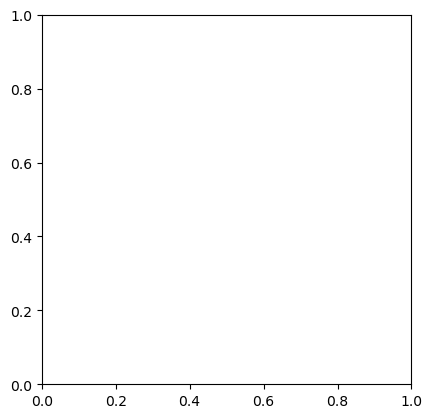

In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread(str(cfg.data_root/"processed"/"aligned.png"))
tgt = cv2.imread(str(cfg.data_root/"processed"/"eels"/"cleaned.png"))
# stacked = np.hstack((img, tgt))
plt.imshow(img)

In [12]:
# select a points in a map (could be an detecting an object unsupervised)
import numpy as np
import cv2

img_path = cfg.data_root/"processed"/"images"/"ext_max.png"
img = cv2.imread(str(img_path))

def get_region(img:np.ndarray, 
               left_corner:tuple[int, int], 
               right_corner:tuple[int, int])->np.ndarray: 
    return img[:, 20:120]

region_of_interest = get_region(img, (0,10), (80, 80))
plt.imshow(region_of_interest)

[ WARN:0@570.279] global /home/conda/feedstock_root/build_artifacts/libopencv_1671461518131/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/thinkpad/projects/dreidel/data/processed/images/ext_max.png'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable